Size: 20000, Noise: 0.1, Train Acc: 0.9997, Test Acc: 0.9990, Mean Error: 0.0006, Topological Penalty: 18646.8955


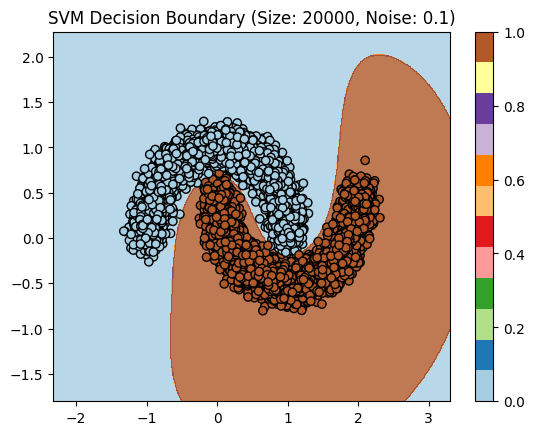

Size: 20000, Noise: 0.2, Train Acc: 0.9726, Test Acc: 0.9720, Mean Error: 0.0277, Topological Penalty: 10627.7895


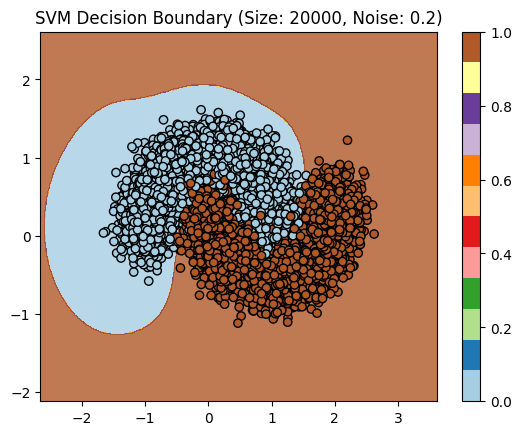

Size: 20000, Noise: 0.3, Train Acc: 0.9134, Test Acc: 0.9180, Mean Error: 0.0843, Topological Penalty: 3624.8678


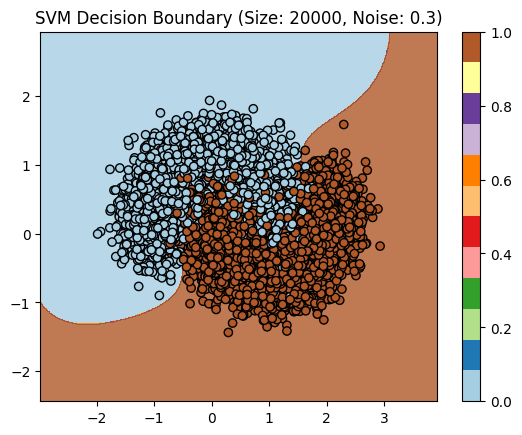

Size: 20000, Noise: 0.4, Train Acc: 0.8626, Test Acc: 0.8675, Mean Error: 0.1349, Topological Penalty: 1883.2649


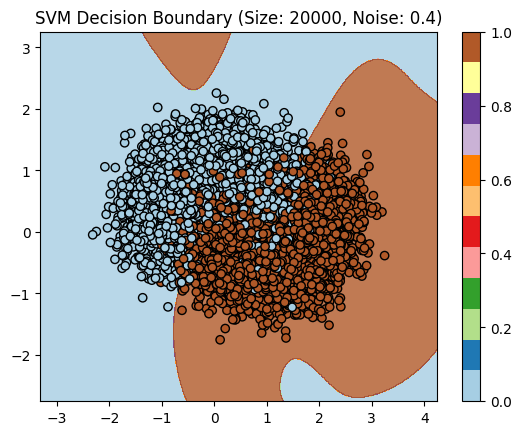

Size: 20000, Noise: 0.5, Train Acc: 0.8212, Test Acc: 0.8255, Mean Error: 0.1766, Topological Penalty: 1566.8325


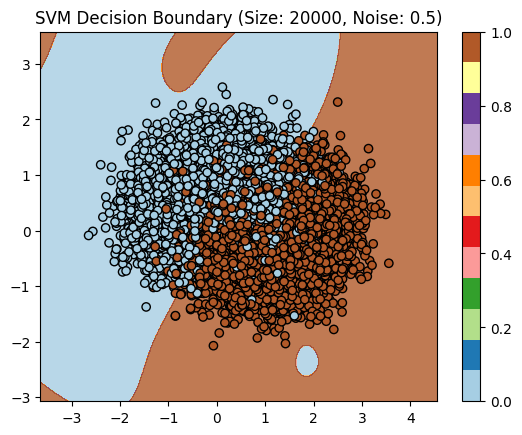

Size: 20000, Noise: 0.6, Train Acc: 0.7926, Test Acc: 0.7938, Mean Error: 0.2068, Topological Penalty: 1274.7641


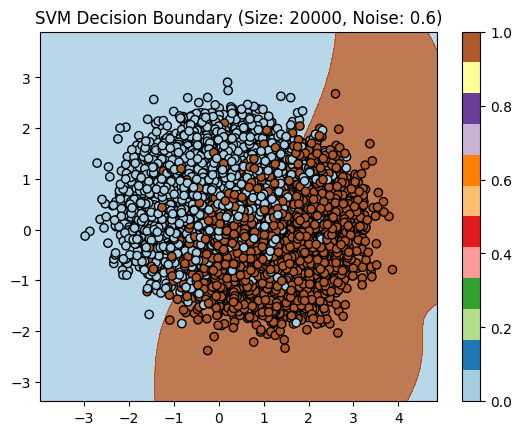

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n
        self.min_point = [i for i in range(n)]

    def find(self, u):
        if self.parent[u] != u:
            self.parent[u] = self.find(self.parent[u])
        return self.parent[u]

    def union(self, u, v, sorted_values):
        root_u = self.find(u)
        root_v = self.find(v)
        if root_u != root_v:
            if self.rank[root_u] > self.rank[root_v]:
                self.parent[root_v] = root_u
                self.min_point[root_u] = min(self.min_point[root_u], self.min_point[root_v], key=lambda p: sorted_values[p])
            elif self.rank[root_u] < self.rank[root_v]:
                self.parent[root_u] = root_v
                self.min_point[root_v] = min(self.min_point[root_u], self.min_point[root_v], key=lambda p: sorted_values[p])
            else:
                self.parent[root_v] = root_u
                self.rank[root_u] += 1
                self.min_point[root_u] = min(self.min_point[root_u], self.min_point[root_v], key=lambda p: sorted_values[p])

    def find_min(self, u):
        return self.min_point[self.find(u)]

def compute_topological_penalty(X, values):
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    uf = UnionFind(len(X))
    critical_pairs = []

    for i, u in enumerate(sorted_indices):
        if i > 0:
            v = sorted_indices[i - 1]
            uf.union(u, v, sorted_values)
            min_v = uf.find_min(v)
            if sorted_values[min_v] <= 0 and sorted_values[u] >= 0:
                critical_pairs.append((min_v, u))
    
    robustness = [min(abs(values[p1]), abs(values[p2])) for p1, p2 in critical_pairs]
    return robustness

def train_svm(X_train, y_train, param_grid):
    svm = SVC()
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_svm = SVC(**best_params)
    best_svm.fit(X_train, y_train)
    return best_svm, best_params

def evaluate_svm(svm, X_train, X_test, y_train, y_test, lambda_):
    train_acc = svm.score(X_train, y_train)
    test_acc = svm.score(X_test, y_test)
    decision_values = svm.decision_function(X_train)
    robustness = compute_topological_penalty(X_train, decision_values)
    topological_penalty = lambda_ * sum(r**2 for r in robustness)
    return train_acc, test_acc, 1.0 - np.mean([train_acc, test_acc]), topological_penalty

def plot_svm_boundary(X, y, svm, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired, marker='o')
    plt.title(title)
    plt.colorbar()
    plt.show()

def pipeline(sizes, noises, lambda_):
    param_grid = {'C': [5, 10, 20, 30, 40], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']}
    results = []
    
    for n in sizes:
        for noise in noises:
            X, y = make_moons(n_samples=n, noise=noise, random_state=42)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            
            svm, best_params = train_svm(X_train, y_train, param_grid)
            train_acc, test_acc, mean_err, topological_penalty = evaluate_svm(svm, X_train, X_test, y_train, y_test, lambda_)
            
            results.append({'size': n, 'noise': noise, 'train_acc': train_acc, 'test_acc': test_acc, 'mean_err': mean_err, 'top_penalty': topological_penalty})
            
            print(f"Size: {n}, Noise: {noise}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Mean Error: {mean_err:.4f}, Topological Penalty: {topological_penalty:.4f}")
            
            plot_svm_boundary(X_train, y_train, svm, f'SVM Decision Boundary (Size: {n}, Noise: {noise})')
    
    return results

sizes = [1000, 5000, 10000, 20000]
noises = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
lambda_ = 0.2
results = pipeline(sizes, noises, lambda_)